# Analyzing Ptychography data using pycroscopy
### Alex Belianinov, Stephen Jesse, Suhas Somnath, and Chris R. Smith, 
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>

Here, we will be working with ptychography datasets acquired using a scanning transmission electron microscope (STEM). These ptychography datsets have four dimensions - two (x, y) dimensions from the position of the electron beam and each spatial pixel contains a two dimensional (u, v) image, called a ronchigram, recorded by the detector. Though the ronchigrams are typically averaged to two values (bright field, dark field), retaining the raw ronchigrams enables deeper investigation of data to reveal the existence of different phases in the material and other patterns that would not be visible in the averaged data

## Configure the notebook first

In [1]:
# Import necessary libraries:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display
import ipywidgets as widgets
import pycroscopy as px
from sklearn.cluster import KMeans

# set up notebook to show plots within the notebook
% matplotlib inline

## Load pycroscopy compatible ptychography dataset

For simplicity we will use a dataset that has already been transalated form its original data format into a pycroscopy compatible hierarchical data format (HDF5 or H5) file

#### H5 files:
* are like smart containers that can store matrices with data, folders to organize these datasets, images, metadata like experimental parameters, links or shortcuts to datasets, etc.
* are readily compatible with high-performance computing facilities
* scale very efficiently from few kilobytes to several terabytes
* can be read and modified using any language including Python, Matlab, C/C++, Java, Fortran, Igor Pro, etc.

In [2]:
# Select a file to work on:
h5_path = r"/Users/ba8/Desktop/20120212_21_GB_float32_downsampled64x64.h5"
print('Working on:\n' + h5_path)
# Open the file
h5_file = h5py.File(h5_path, mode='r+')

Working on:
/Users/ba8/Desktop/20120212_21_GB_float32_downsampled64x64.h5


## Inspect the contents of this h5 data file
The file contents are stored in a tree structure, just like files on a contemporary computer.
The data is stored as a 2D matrix (position, spectroscopic value) regardless of the dimensionality of the data.  
In the case of these 4D ptychography datasets, the data is stored as a N x P dataset where N is the number of spatial positions of the electron beam and P is the number of pixels in the detector. 

The main dataset is always accompanied by four ancillary datasets that explain the position and spectroscopic value of any given element in the dataset.
In the case of the 2d images, the positions will be arranged as row0-col0, row0-col1.... row0-colN, row1-col0....
The spectroscopic information is trivial since the data at any given pixel is just a scalar value

In [3]:
print('Datasets and datagroups within the file:\n------------------------------------')
px.hdf_utils.print_tree(h5_file)
 
print('\nThe main dataset:\n------------------------------------')
print(h5_file['/Measurement_000/Channel_000/Raw_Data'])
print('\nThe ancillary datasets:\n------------------------------------')
print(h5_file['/Measurement_000/Channel_000/Position_Indices'])
print(h5_file['/Measurement_000/Channel_000/Position_Values'])
print(h5_file['/Measurement_000/Channel_000/Spectroscopic_Indices'])
print(h5_file['/Measurement_000/Channel_000/Spectroscopic_Values'])

print('\nMetadata or attributes in a datagroup\n------------------------------------')
for key in h5_file['/Measurement_000'].attrs:
    print('{} : {}'.format(key, h5_file['/Measurement_000'].attrs[key]))

Datasets and datagroups within the file:
------------------------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Mean_Ronchigram
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Raw_Data-Cluster_000
Measurement_000/Channel_000/Raw_Data-Cluster_000/Cluster_Indices
Measurement_000/Channel_000/Raw_Data-Cluster_000/Cluster_Values
Measurement_000/Channel_000/Raw_Data-Cluster_000/Label_Spectroscopic_Indices
Measurement_000/Channel_000/Raw_Data-Cluster_000/Label_Spectroscopic_Values
Measurement_000/Channel_000/Raw_Data-Cluster_000/Labels
Measurement_000/Channel_000/Raw_Data-Cluster_000/Mean_Response
Measurement_000/Channel_000/Raw_Data-Cluster_000/Mean_Response_Indices
Measurement_000/Channel_000/Raw_Data-Cluster_000/Mean_Response_Values
Measurement_000/Channel_000/Raw_Data-Cluster_001
Measurement_000/Channel_000/Raw_Data-Cluster_001/Cluster_Indices
M

## Read some basic parameters for visualization

In [4]:
# Select the dataset containing the raw data to start working with:
h5_main = px.hdf_utils.getDataSet(h5_file, 'Raw_Data')[-1]

# Read some necessary parameters:
h5_pos_inds = px.hdf_utils.getAuxData(h5_main, auxDataName=['Position_Indices'])[0]
num_rows = len(np.unique(h5_pos_inds[:, 0]))
num_cols = len(np.unique(h5_pos_inds[:, 1]))
h5_spec_inds = px.hdf_utils.getAuxData(h5_main, auxDataName=['Spectroscopic_Indices'])[0]
num_sensor_rows = len(np.unique(h5_spec_inds[0, :]))
num_sensor_cols = len(np.unique(h5_spec_inds[1, :]))

/Users/ba8/anaconda3/lib/python3.5/site-packages/pycroscopy/io/hdf_utils.py:612: UserWarning: units attribute was missing
  warn('units attribute was missing')


## Visualize the Raw Ronchigrams

/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  


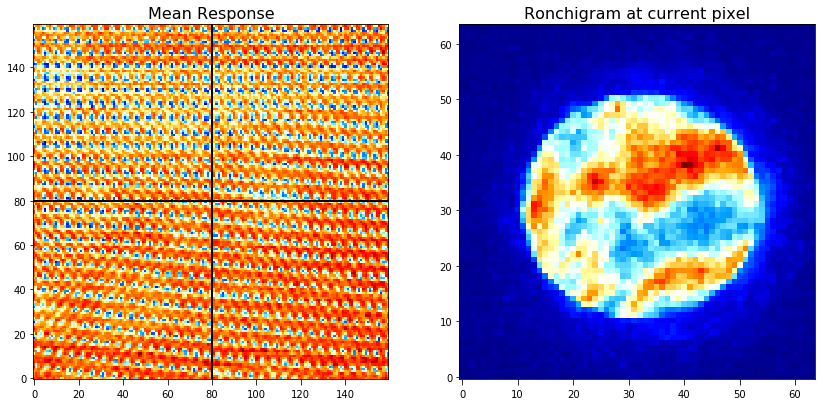

In [5]:
coarse_row = int(0.5*num_rows)
coarse_col = int(0.5*num_cols)
coarse_pos = coarse_row * num_rows + coarse_col

current_ronch = np.reshape(h5_main[coarse_pos], (num_sensor_rows, num_sensor_cols))

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
axes[0].hold(True)
axes[0].set_title('Mean Response')
axes[0].imshow(np.reshape(h5_main.parent['Spectroscopic_Mean'], (num_rows, num_cols)), 
               cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')
main_vert_line = axes[0].axvline(x=coarse_col, color='k')
main_hor_line = axes[0].axhline(y=coarse_row, color='k')
axes[1].set_title('Ronchigram at current pixel')
img_zoom = axes[1].imshow(current_ronch,cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')

def move_zoom_box(coarse_row, coarse_col):
    main_vert_line.set_xdata(coarse_col)
    main_hor_line.set_ydata(coarse_row)
    
    coarse_pos = coarse_row * num_rows + coarse_col
    current_ronch = np.reshape(h5_main[coarse_pos], (num_sensor_rows, num_sensor_cols))

    img_zoom.set_data(current_ronch)
    #img_zoom.set_clim(vmax=ronch_max, vmin=ronch_min)
    display(fig)

widgets.interact(move_zoom_box, coarse_row=(0, num_rows, 1), 
                 coarse_col=(0, num_cols, 1));

## Performing Singular Value Decompostion (SVD)
SVD decomposes data (arranged as position x value) into a sequence of orthogonal components arranged in descending order of variance. The first component contains the most significant trend in the data. The second component contains the next most significant trend orthogonal to all previous components (just the first component). Each component consists of the trend itself (eigenvector), the spatial variaion of this trend (eigenvalues), and the variance (statistical importance) of the component.

Here, SVD essentially compares every single ronchigram with every other ronchigram to find statistically significant trends in the dataset. Such correlation would be infeasible if the ronchigrams were averaged to bright-field and dark-field scalar values. 

In [6]:
# First check if SVD was already computed on this dataset:
h5_svd_group = px.hdf_utils.findH5group(h5_main, 'SVD')
if len(h5_svd_group) == 0:
    print('No prior SVD results found - doing SVD now')
    do_svd = px.processing.svd_utils.SVD(h5_main, num_components=256)
    h5_svd_group = do_svd.compute()

    h5_u = h5_svd_group['U']
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']
else:
    print('Taking previous SVD results already present in file')
    h5_svd_group = h5_svd_group[-1]
    
    h5_u = h5_svd_group['U']
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']

num_comps = 16

Taking previous SVD results already present in file


## Visualize the SVD results

##### S (variance):
The plot below shows the variance or statistical significance of the SVD components. The first few components contain the most significant information while the last few components mainly contain noise. 

Note also that the plot below is a log-log plot. The importance of each subsequent component drops exponentially.

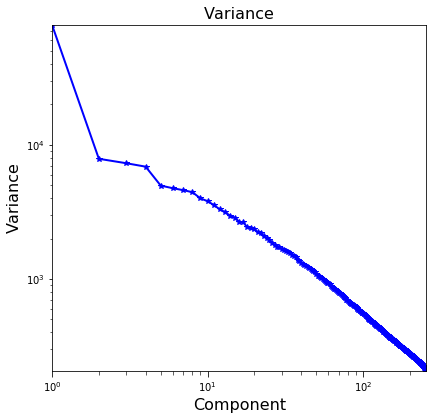

In [7]:
# Visualize variance of the principal components

fig, axes = px.plot_utils.plot_scree(h5_s, title='Variance')

#### U (Eigenvalues or loading maps):
The plot below shows the spatial distribution of each SVD component

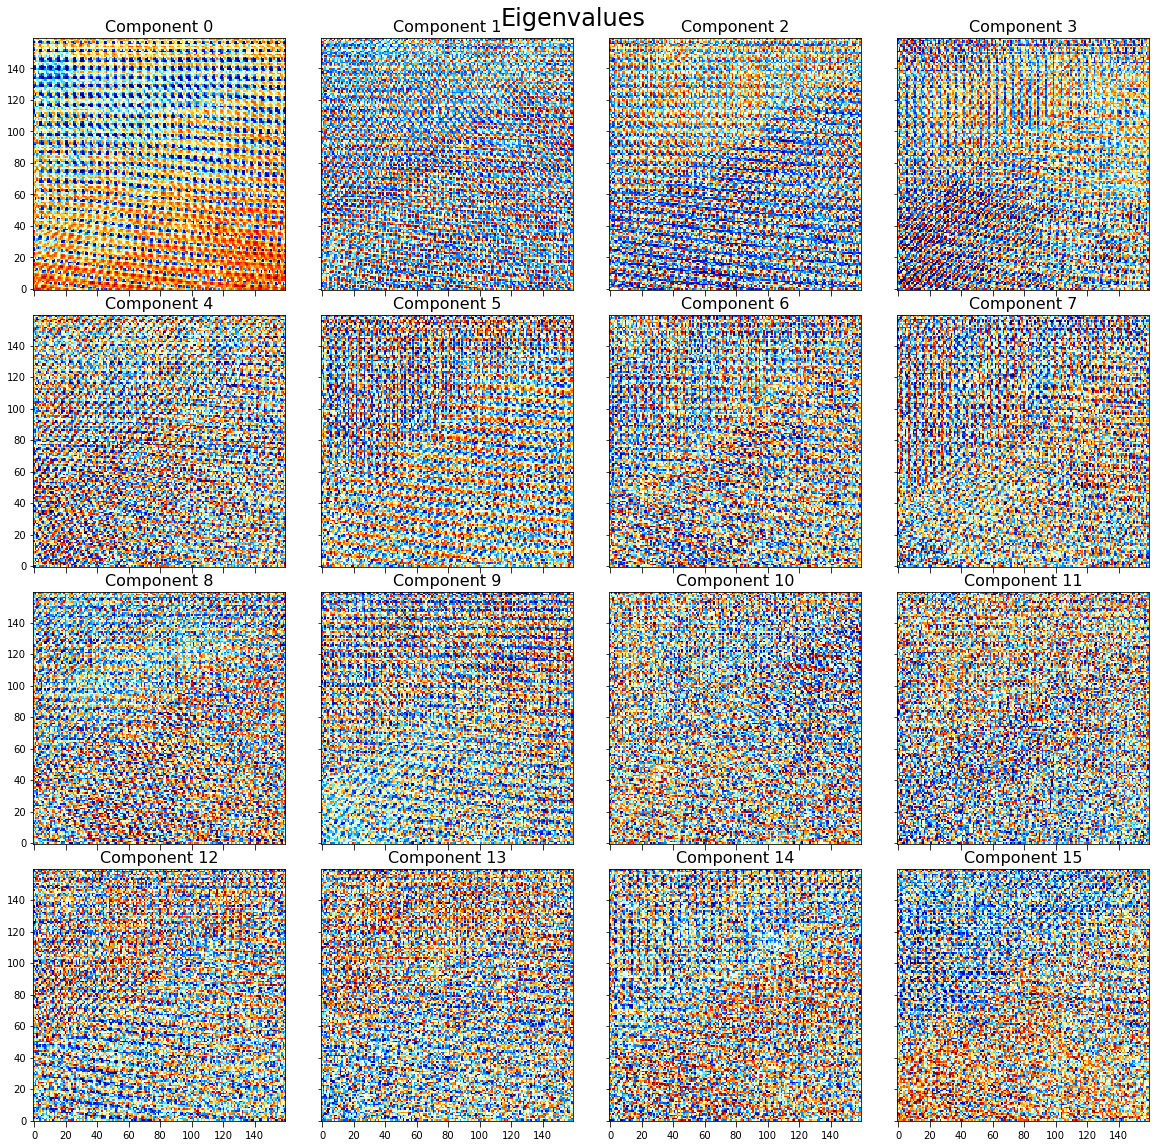

In [24]:
# Visualize the eigenvalues or loading maps from SVD:
loadings = np.reshape(h5_u[:, :num_comps], (num_rows, num_cols, -1))
fig, axes = px.plot_utils.plot_map_stack(loadings, num_comps=num_comps, heading='Eigenvalues',
                                         cmap=px.plot_utils.cmap_jet_white_center())

#### V (Eigenvectors)
The V dataset contains the eigenvectors for each component

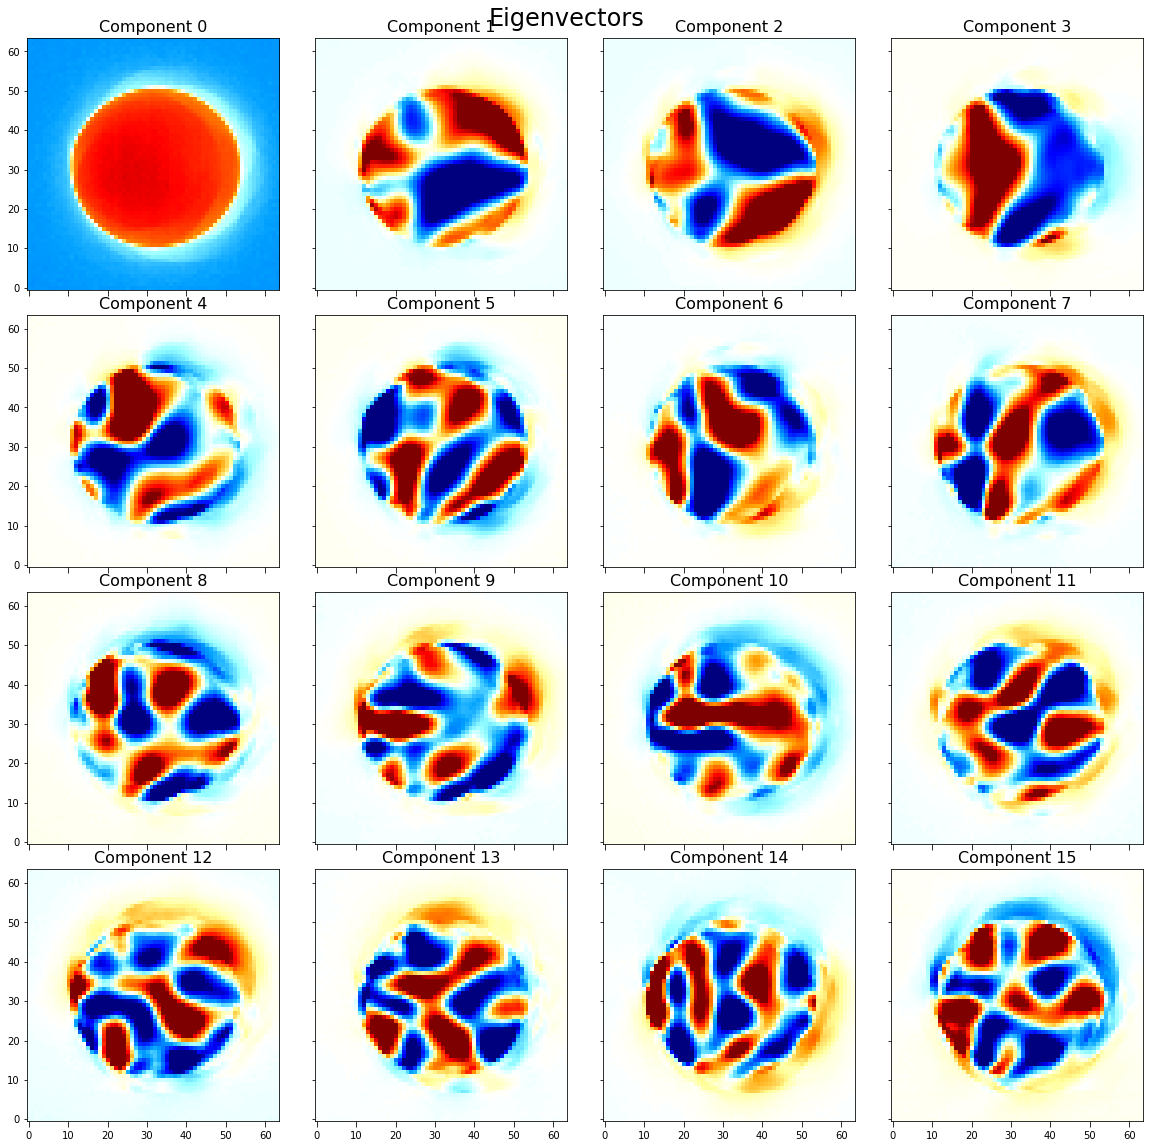

In [25]:
# Visualize the eigenvectors from SVD:
eigenvectors = np.reshape(h5_v[:num_comps], (-1, num_sensor_rows, num_sensor_cols))
eigenvectors = np.transpose(eigenvectors, (1, 2, 0))
fig, axes = px.plot_utils.plot_map_stack(eigenvectors, num_comps=num_comps, heading='Eigenvectors',
                                         cmap=px.plot_utils.cmap_jet_white_center())

## Clustering
Clustering divides data into k clusters such that the variance within each cluster is minimized. 

In principle, clustering can be perfomed on any dataset that has some spectral values (eg. - ronchgirams in the case of the raw dataset or an array of values for each SVD component) for each position. However, the computation time increases with the size of the dataset.

Here, we will be performing k-means clustering on the U matrix from SVD. 
We want a large enough number of clusters so that K-means identifies fine nuances in the data. At the same time, we want to minimize computational time by reducing the number of clusters. We recommend 32 clusters.

In [26]:
# Attempt to find any previous computation
h5_kmeans_group = px.hdf_utils.findH5group(h5_u, 'Cluster')
if len(h5_kmeans_group) == 0:
    print('No k-Means computation found. Doing K-Means now')
    num_clusters = 32
    num_comps_for_clustering = 128
    estimator = px.Cluster(h5_main, KMeans(n_clusters=num_clusters), num_comps = num_comps_for_clustering)
    h5_kmeans_group = estimator.compute(h5_main)
else:
    print('Taking existing results of previous K-Means computation')
    h5_kmeans_group = h5_kmeans_group[-1]
    
h5_labels = h5_kmeans_group['Labels']
h5_centroids = h5_kmeans_group['Mean_Response']

# In case we take existing results, we need to get these parameters
num_clusters = h5_centroids.shape[0]
num_comps_for_clustering = h5_centroids.shape[1]

No k-Means computation found. Doing K-Means now
WARNING! Cluster has already been performed with the same parameters before. Consider reusing results
<HDF5 group "/Measurement_000/Channel_000/Raw_Data-Cluster_000" (8 members)>
Performing clustering on /Measurement_000/Channel_000/Raw_Data.
Calculated the Mean Response of each cluster.
Writing clustering results to file.


#### Visualize k-means results

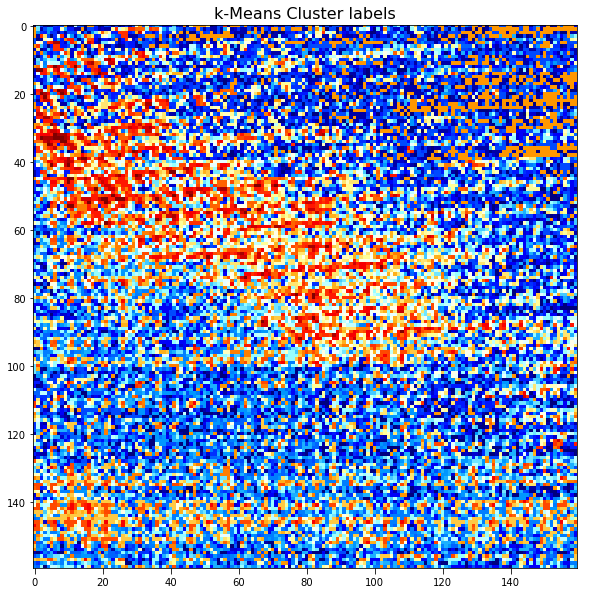

In [27]:
label_mat = np.reshape(h5_labels, (num_rows, num_cols))
fig, axis = plt.subplots(figsize=(10,10))
axis.imshow((label_mat), cmap=px.plot_utils.cmap_jet_white_center())
axis.set_title('k-Means Cluster labels');

#### Visualize the Dendrogram
The vertical length of the branches indicates the relative separation between neighboring clusters.

Creating full dendrogram from clusters


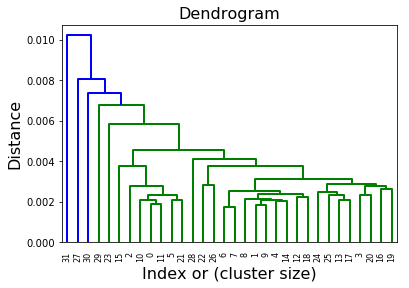

In [13]:
e_vals = np.reshape(h5_u[:, :num_comps_for_clustering], 
                    (num_rows, num_cols, -1))
fig = px.plot_utils.plot_cluster_dendrogram(label_mat, e_vals, 
                                            num_comps_for_clustering, 
                                            num_clusters, 
                                            last=num_clusters);

### Save and close
* Save the .h5 file that we are working on by closing it. <br>
* Also, consider exporting this notebook as a notebook or an html file. <br> To do this, go to File >> Download as >> HTML
* Finally consider saving this notebook if necessary

In [14]:
Hdf = px.ioHDF5(h5_file)
Hdf.repack()

In [16]:
h5_file.close()

ValueError: Not a file id (Not a file id)